In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import time
# from sklearn.externals import joblib
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.head(2)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021/1/2,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48
1,5,eb766123-9f24-436e-9117-49c739816794,B07VLKMMJ5,2021/1/2,COSORI Smart WiFi Air Fryer 5.8QT(100 Recipes)...,44065.1400,0.0400,0.4500,367,0.0200,-0.1000,0.4400,2.0000,120.0700,0.0000,11543.0000,-0.0100,1.4500,0.0300,0.0100,0.0200,1.2600,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [27]:
data.groupby(['asin']).sum()['ordered_units'].sort_values()

asin
B07G9J4745         0
B097HG13D1         6
B09BB74CLW        12
B0999CJBD9        85
B08YDQSG55       169
B08PC1WNNX       205
B08THPNHJK       224
B08LYY2HHJ       421
B08FX4BR51       529
B07VNPQ2NF       552
B095346VH6       572
B08QM92YBH       581
B071D7BTTW       640
B07QDSHKV1       953
B07RWPQ9TM      1208
B08NSVZY1K      1220
B08L3L4ZZX      1391
B076DZJSHL      1760
B07WZF33ZT      2760
B07X3JDVHK      3290
B07YL6QWLK      3907
B081NLFM91      4863
B07T4HX1LH      4978
B07XS37FPV      5108
B07W8MGPJX      5279
B08GBY2BK8      5301
B07VXQMR7G      5591
B08L39951F      5719
B07SKJV5KV      6169
B08BFMV68M      6170
B08BFS92RP      6401
B07T1BCN91      7510
B089ZT66H9      7571
B0895G46CG      8032
B07YBB5SKG      8138
B07WYYRZK7      9139
B081LQMXKP      9743
B07LCW5S2H     10568
B08K8T3W2V     10842
B07X2JP8HP     10894
B083JBM9CZ     13760
B0895GS9NW     13830
B07FP5PHG4     14736
B07VXVFKWV     16760
B07QDSNFS2     18376
B074NYJL9J     18540
B08PP48979     25266
B0821DTM

In [3]:
data.data_date = pd.to_datetime(data.data_date)

In [5]:
train = data[(data['data_date'] >= '2019-12-02')
              & (data['data_date'] <= '2021-07-22') 
              & ((data.asin == 'B07FKN76ZS') | 
                 (data.asin =='B07QHSZGXC'))].copy()[['data_date', 'asin', 'ordered_units']]

In [43]:
test = data[(data['data_date'] >= '2021-07-23')
             & (data['data_date'] <= '2021-08-22')
            & ((data.asin == 'B07FKN76ZS') | 
               (data.asin =='B07QHSZGXC'))].copy()[['data_date', 'asin', 'ordered_units']]

In [6]:
train = train.groupby(['asin', 'data_date']).sum().reset_index()
test = test.groupby(['asin', 'data_date']).sum().reset_index()

In [7]:
train.head(2).append(train.tail(2))

,asin,data_date,ordered_units
0,B07FKN76ZS,2019-12-02,2667
1,B07FKN76ZS,2019-12-03,684
1183,B07QHSZGXC,2021-07-21,160
1184,B07QHSZGXC,2021-07-22,171


## ordered_units

In [8]:
from scipy.stats import norm

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

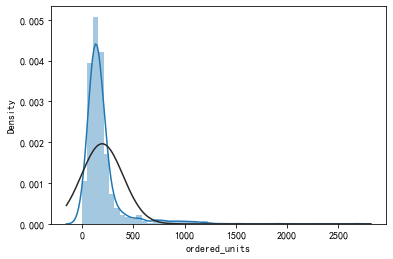

In [9]:
sns.distplot(train.ordered_units, kde=True, fit=norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [12]:
train.drop(train[train.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

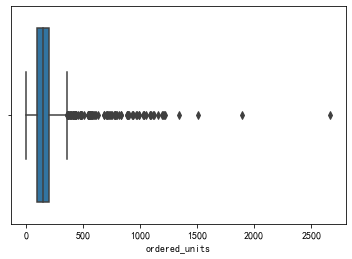

In [13]:
sns.boxplot(train.ordered_units)

In [14]:
train.drop(train[train.ordered_units > 1500].index, inplace=True)

In [15]:
train.shape

(1169, 3)

### 缺失值

In [16]:
train.isnull().sum()

asin             0
data_date        0
ordered_units    0
dtype: int64

无缺失值不用处理

### 创造特征

In [17]:
train['year'] = train.data_date.dt.year
train['month'] = train.data_date.dt.month
train['day'] = train.data_date.dt.day
train = train.drop('data_date', axis=1)

In [18]:
train.head(1)

,asin,ordered_units,year,month,day
1,B07FKN76ZS,684,2019,12,3


In [19]:
x_train = train.drop('ordered_units', axis=1)
y_train = train['ordered_units']

In [22]:
train.ordered_units.sum()

227339

In [21]:
train.shape

(1169, 5)

<AxesSubplot:xlabel='year', ylabel='ordered_units'>

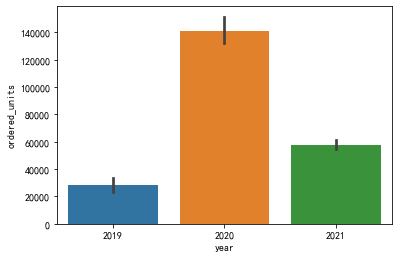

In [20]:
sns.barplot('year', 'ordered_units', data=train, estimator=np.sum)

<AxesSubplot:xlabel='day', ylabel='ordered_units'>

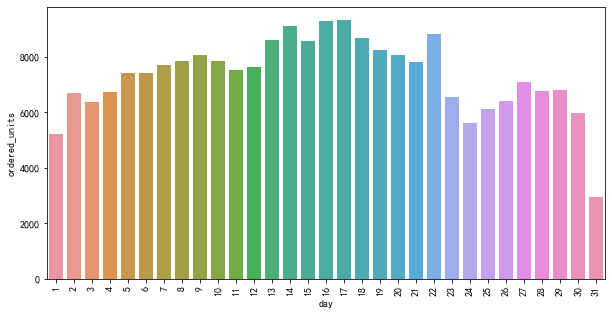

In [28]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot('day', 'ordered_units', data=train, ci=0, estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='ordered_units'>

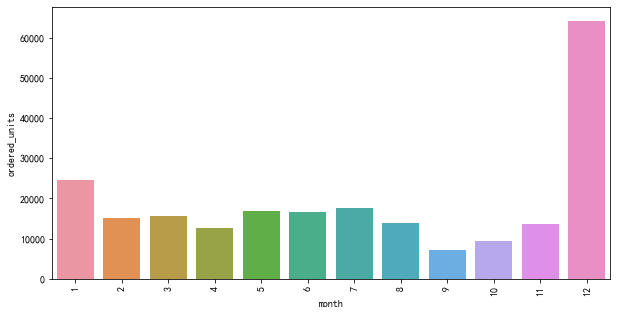

In [29]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot('month', 'ordered_units', data=train, ci=0, estimator=np.sum)

### 编码

In [30]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_train.shape

(1169, 48)

## ordered_units

In [8]:
from scipy.stats import norm

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

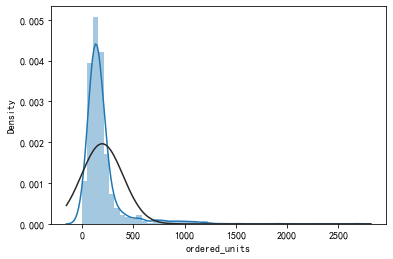

In [9]:
sns.distplot(train.ordered_units, kde=True, fit=norm)

## 训练

In [31]:
dtrain = xgb.DMatrix(x_train, y_train)

In [99]:
ts = time.time()
params = {'eta': 0.1,
          'gamma': 5,
          'max_depth': 4,
          'subsample': 1,
          'colsample_bytree': 1,
          'min_child_weight': 15,
          'n_jobs': 8}
model = xgb.train(params, dtrain, 1500)
time.time() - ts

0.843977689743042

In [100]:
result_cv = xgb.cv(params, dtrain, num_boost_round=1500)

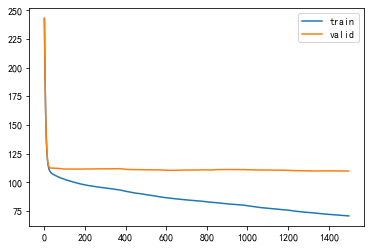

In [101]:
plt.plot(result_cv.iloc[:, 0], label='train')
plt.plot(result_cv.iloc[:, 2], label='valid')
plt.legend()

## 评判标准

- 分开
- 添加特征，weekday
- 赋予权重

In [143]:
def metrics1(y_true, y_pred):
    return 1 - (abs(y_true.sum() - y_pred.sum()) / y_true.sum())

In [144]:
def metrics2(y_true, y_pred):
    return 1 - (abs(y_true - y_pred) / y_true).mean()

## 测试3：B07FKN76ZS, 电水壶

In [128]:
def create_feature(asin):
    test1 = test[test['asin'] == asin]
    # 对测试数据构造特征
    test1['year'] = test1.data_date.dt.year
    test1['month'] = test1.data_date.dt.month
    test1['day'] = test1.data_date.dt.day
    test1.drop('data_date', axis=1, inplace=True)
    return test1

In [129]:
test3 = create_feature('B07FKN76ZS')
test3.head(1)

,asin,ordered_units,year,month,day
26990,B07FKN76ZS,136,2021,7,26


In [141]:
x_test_3 = test3.drop('ordered_units', axis=1)
y_test_3 = test3['ordered_units']
x_test_3.head(10)

,asin,year,month,day
26990,B07FKN76ZS,2021,7,26
27050,B07FKN76ZS,2021,7,25
27114,B07FKN76ZS,2021,7,24
27173,B07FKN76ZS,2021,7,23
27232,B07FKN76ZS,2021,7,27
27350,B07FKN76ZS,2021,7,31
27412,B07FKN76ZS,2021,8,1
27475,B07FKN76ZS,2021,8,2
27536,B07FKN76ZS,2021,8,3
27594,B07FKN76ZS,2021,8,5


In [145]:
x_test_encoded = encoder.transform(x_test_3)
dtest = xgb.DMatrix(x_test_encoded, y_test_3)
y_pred_3 = model.predict(dtest)
metrics1(y_test_3, y_pred_3), metrics2(y_test_3, y_pred_3)

(-0.44929247423054597, -0.6558902167100327)

In [132]:
y_test_3

26990    136
27050     93
27114     70
27173     75
27232     98
27350     80
27412    114
27475     89
27536     57
27594     69
27653     72
27713     58
27771     95
27832     81
27892     75
27948     88
28009     85
28068     67
28129     89
28191     78
28252    100
28314     85
28372     80
28434     76
28493     79
28554     82
28614     77
28674     84
28734     84
28794     83
28855     84
Name: ordered_units, dtype: int64

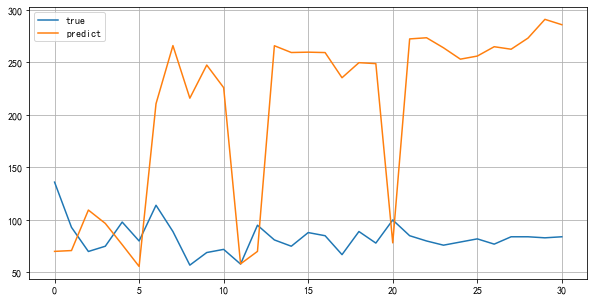

In [133]:
plt.figure(figsize=(10,5))
plt.plot(y_test_3.values, label='true')
plt.plot(y_pred_3, label='predict')
plt.grid()
plt.legend()

## 测试4：B07QHSZGXC, 炸锅配件

In [134]:
test4 = create_feature('B07QHSZGXC')

In [135]:
x_test_4 = test4.drop('ordered_units', axis=1)
y_test_4 = test4['ordered_units']

In [136]:
x_test_4 = encoder.transform(x_test_4)
dtest = xgb.DMatrix(x_test_4, y_test_4)
y_pred_4 = model.predict(dtest)

In [137]:
metrics(y_test_4, y_pred_4)

0.7953339633562707

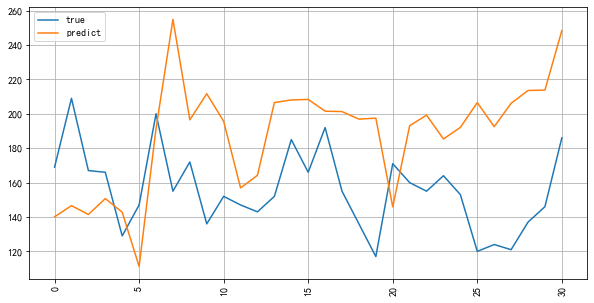

In [138]:
plt.figure(figsize=(10,5))
plt.plot(y_test_4.values, label='true')
plt.plot(y_pred_4, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()